<pre>
█▄▀ █░░ ▄▀█ █▀ █▄█ █▀▀ █ █▄▀ ▄▀█ ▀█▀ █▀█ █▀█   █▄▄ ▄▀█ ░░█ █▀▀ █▀ █▀█ █░█░█ █▀ █▄▀ █   
█░█ █▄▄ █▀█ ▄█ ░█░ █▀░ █ █░█ █▀█ ░█░ █▄█ █▀▄   █▄█ █▀█ █▄█ ██▄ ▄█ █▄█ ▀▄▀▄▀ ▄█ █░█ █   

▀█▀ █░█ █▀▀   █▀▀ █▀█ █▀▀ ▄▀█ ▀█▀   █▀▄▀█ █▀█ █▀▀   █▀▀ █▀▄ █ ▀█▀ █ █▀█ █▄░█
░█░ █▀█ ██▄   █▄█ █▀▄ ██▄ █▀█ ░█░   █░▀░█ █▄█ █▄█   ██▄ █▄▀ █ ░█░ █ █▄█ █░▀█ 
(AKA I copied it from someone smarter than both me and chatGPT vomit edition)
</pre>

Podziękowania
Chciałbym serdecznie podziękować autorowi artykułu "Naive Bayes and Hyperparameter Optimization", który jest autorem najlepszego tutoriala dot. AI jaki widziałem, bez niego mog edition to byłoby chatGPT edition. 

Opis
Artykuł "Naive Bayes and Hyperparameter Optimization" przedstawia w sposób przystępny podstawy klasyfikatora Naive Bayes oraz techniki optymalizacji hiperparametrów. Obejmuje zarówno teoretyczne aspekty, jak i praktyczne przykłady implementacji w Pythonie, co czyni go wartościowym źródłem wiedzy dla osób zainteresowanych uczeniem maszynowym.

Link do artykułu: [Naive Bayes and Hyperparameter Optimization](https://bait509-ubc.github.io/BAIT509/lectures/lecture6.html)

### Zalety i wady naiwnego klasyfikatora Bajesowskiego w kontekście naszego projektu

**Zalety**

- **Mniejsza złożoność:** Naïve Bayes jest prostszy w porównaniu do innych klasyfikatorów. 
- **Dobra skalowalność:** Jest szybki i efektywny, a także wymaga niewielkiej ilości pamięci.
- **Obsługa danych o wysokiej wymiarowości:** Sprawdza się w przypadkach takich jak klasyfikacja dokumentów, gdzie liczba wymiarów jest wysoka.

**Wady**

- **Zjawisko zerowej częstości:** Występuje, gdy zmienna kategoryczna nie istnieje w zbiorze treningowym, co prowadzi do zerowego prawdopodobieństwa warunkowego. Problem ten można rozwiązać za pomocą wygładzania Laplace’a.
- **Nierealistyczne założenie podstawowe:** Założenie o niezależności warunkowej nie zawsze jest spełnione, co może prowadzić do błędnych klasyfikacji.

**Zastosowania klasyfikatora Naïve Bayes**

- **Filtrowanie spamu:** Jedno z najpopularniejszych zastosowań, gdzie Naïve Bayes służy do klasyfikacji wiadomości jako spam.
- **Klasyfikacja dokumentów:** Używany do klasyfikacji treści, np. artykułów na stronach mediów informacyjnych.
- **Analiza sentymentu:** Pomaga w zrozumieniu opinii i postaw wobec produktów i marek.
- **Przewidywanie stanów umysłowych:** Wykorzystywany w analizie danych fMRI do przewidywania stanów poznawczych ludzi.
źródło IBM


| Nazwa klasyfikatora      | Opis                                                                                       | Założenie                                                     | Nadaje się do                                                    | Przyjęto (wyjaśnienie)    |
|--------------------------|--------------------------------------------------------------------------------------------|---------------------------------------------------------------|------------------------------------------------------------------|--------------------------|
| Gaussian Naive Bayes     | Zakłada normalny (gaussowski) rozkład cech w każdej klasie.                                | Cechy mają ciągły rozkład gaussowski.                         | Numeryczne cechy, które są w przybliżeniu normalnie rozłożone.    |✅|
| Multinomial Naive Bayes  | Zaprojektowany dla dyskretnych danych opartych na liczeniu (np. dane tekstowe reprezentowane przez częstotliwość słów). | Cechy są liczbami wystąpień w różnych klasach.                 | Klasyfikacja tekstów, kategoryzacja dokumentów, analiza sentymentu. |❌✅|
| Complement Naive Bayes   | Zakłada cechy binarne lub logiczne, wskazujące obecność lub brak cechy.                     | Cechy są binarne (0/1).                                        | Klasyfikacja tekstów, klasyfikacja danych binarnych.              |❌|
| Categorical Naive Bayes  | Obsługuje cechy kategoryczne, które mogą przyjmować dyskretne wartości bez zakładania żadnego określonego rozkładu. | Cechy są zmiennymi kategorycznymi.                             | Klasyfikacja tekstów, systemy rekomendacyjne z danymi kategorycznymi. |✅|
| Bernoulli Naive Bayes    | Zakłada cechy binarne lub logiczne, wskazujące obecność lub brak cechy.                     | Cechy są binarne (0/1).                                        | Klasyfikacja tekstów, klasyfikacja danych binarnych.              |❌|


In [38]:
## Obsolete but maybe useful code repository:
# Pretty pointless tbh, but I'll leave it here for now
# # Split ratios to evaluate
# split_ratios = [0.2, 0.3, 0.4, 0.5]  # 20%, 30%, 40%, 50% test sizes

# # Storage for results
# results = []

# for test_size in split_ratios:
#     # Split data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=2137)

#     # Initial Model Evaluation with Multinomial Naive Bayes
#     gnb = GaussianNB()
#     mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_model(X_train, y_train, gnb)
#     print(f"Mean accuracy score over all folds for test size {test_size}: {mean_accuracy * 100:.2f}%")
#     print(f"Accuracy for the last fold: {accuracy_scores[-1] * 100:.2f}%")

#     # Report Generation for the Last Fold
#     report = generate_report(y_fold_test, y_pred)

#     # Store results
#     results.append({
#         'test_size': test_size,
#         'mean_accuracy': mean_accuracy,
#         'report': report,
#         'y_fold_test': y_fold_test,
#         'y_pred': y_pred,
#         'accuracy_scores': accuracy_scores
#     })

In [39]:
# General libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-learn libraries
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

In [56]:
def initialize_data(scalerType):
    # Wczytanie danych z pliku CSV (X_test.csv, X_train.csv, y_test.csv, y_train.csv)
    X = pd.read_csv('wineData.csv')
    y = pd.read_csv('wineRatings.csv')
    y = y.values.ravel()
    # Wyswietl informacje o danych
    print("X_train shape: ", X.shape, "y_train shape: ", y.shape)

    #Preprocessing danych przy użyciu scalera
    if scalerType == "minmax":
        scaler = MinMaxScaler()
    elif scalerType == "standard":
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        scalerType = None
    return X, y


In [83]:
# Function to evaluate a model using K-Fold Cross Validation
def evaluate_model(X_train, y_train, model, cv_splits=10, random_state=2137):
    # Initialize KFold
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    accuracy_scores = []

    # Split the data into training and testing sets for each fold
    for train_index, test_index in kfold.split(X_train):
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        # Fit the model and make predictions
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_test)
        # Calculate accuracy and append to the list
        accuracy = accuracy_score(y_fold_test, y_pred)
        accuracy_scores.append(accuracy)

    # Calculate mean accuracy
    mean_accuracy = np.mean(accuracy_scores)
    return mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores

# Function to generate a classification report
def generate_report(y_test, y_pred):
    # Generate and print classification report and confusion matrix
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    print("Classification report:\n", classification_report(y_test, y_pred, zero_division=1))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    return report

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test, y_pred, ax):
    # Create a DataFrame with actual and predicted values
    test = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    # Plot the values
    test.plot(ax=ax, marker='o')
    ax.legend(['Actual', 'Predicted'])
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')

# Function to plot a confusion matrix
def plot_confusion_matrix(y_test, y_pred, ax):
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot the matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Function to plot metrics from a classification report
def plot_classification_report(report, ax):
    # Convert report to DataFrame and drop 'support' column
    report_df = pd.DataFrame(report).transpose()
    report_df.drop(columns='support', inplace=True)
    # Plot the metrics
    report_df.plot(kind='bar', ax=ax)
    ax.set_title('Classification Report Metrics')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

# Function to optimize hyperparameters using GridSearchCV
def optimize_hyperparameters(X_train, y_train, param_grid, random_state=42, estimator = GaussianNB()):
    # Create a pipeline
    pipe = make_pipeline(SimpleImputer(), StandardScaler(), GaussianNB())
    # Initialize KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    # Initialize GridSearchCV
    grid = GridSearchCV(estimator, param_grid=param_grid, cv=5, scoring='accuracy')

    # Fit the grid
    grid.fit(X_train, y_train)
    # Return the best imputation strategy
    return grid.best_params_

def cross_validation_with_optimized_hyperparameters(X_train, y_train, model, best_strategy, cv_splits=5, random_state=42, model_name = 'GaussianNB'):
    # Set the var_smoothing parameter of the model
    if model_name == 'GaussianNB':
        model.var_smoothing = best_strategy['var_smoothing']
    # Create a pipeline with the optimized strategy
    pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler(), model)
    # Initialize KFold
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    # Perform cross validation and return the results
    cv_results = cross_validate(pipe, X_train, y_train, cv=kfold, return_train_score=True)
    return cv_results

# Gaussian Naive Bayes

X_train shape:  (1326, 8) y_train shape:  (1326,)
Mean accuracy score over all folds: 54.62%
Accuracy for the last fold: 63.21%
Classification report:
               precision    recall  f1-score   support

           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       0.74      0.83      0.78        47
           6       0.67      0.47      0.55        43
           7       0.47      0.53      0.50        15
           8       0.00      0.00      0.00         1

    accuracy                           0.63       106
   macro avg       0.31      0.64      0.30       106
weighted avg       0.66      0.63      0.64       106

Confusion matrix:
 [[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  1 39  6  1  0]
 [ 2  1 13 20  7  0]
 [ 0  0  1  4  8  2]
 [ 0  0  0  0  1  0]]
Best imputation strategy: {'var_smoothing': 1}
Cross-validation results: {'fit_time': array([0.00299025, 0.00223827, 0.00395703, 0.00203109, 0.00220633]), 'sco

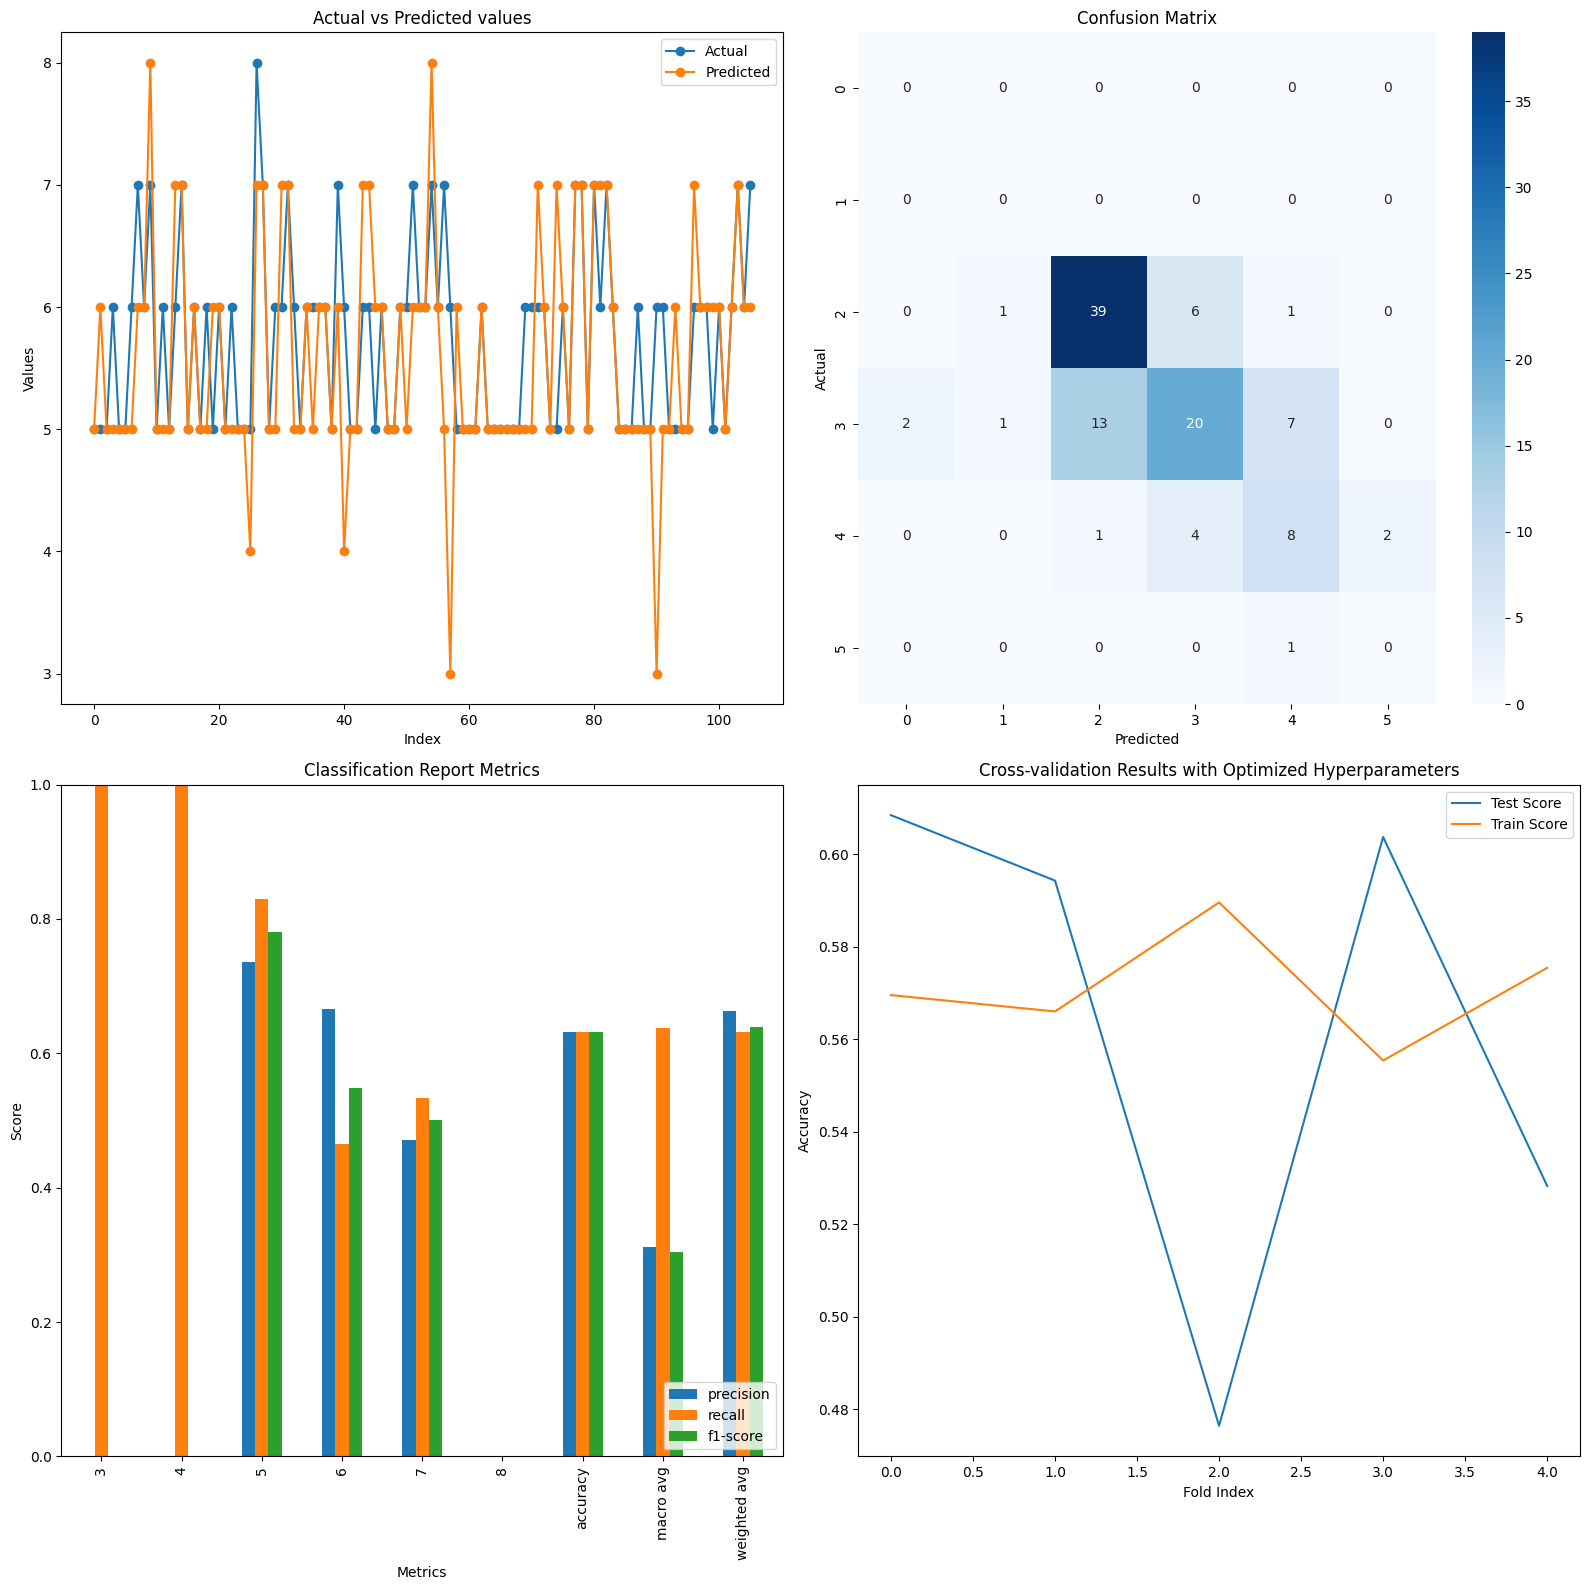

In [86]:
#initialize data
X, y = initialize_data("standard")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)

# Initial Model Evaluation
gnb = GaussianNB()
mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_model(X_train, y_train, gnb)
print(f"Mean accuracy score over all folds: {mean_accuracy * 100:.2f}%")
print(f"Accuracy for the last fold: {accuracy_scores[-1] * 100:.2f}%")

# Report Generation for the Last Fold
report = generate_report(y_fold_test, y_pred)

# Create a matrix layout for plots
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# Plot actual vs predicted values for the last fold
plot_actual_vs_predicted(y_fold_test, y_pred, axs[0, 0])

# Plot confusion matrix for the last fold
plot_confusion_matrix(y_fold_test, y_pred, axs[0, 1])

# Plot classification report for the last fold
plot_classification_report(report, axs[1, 0])

# Hyperparameter Tuning
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}
best_strategy = optimize_hyperparameters(X_train, y_train, param_grid, gnb)
print(f"Best imputation strategy: {best_strategy}")

# Cross-validation with the optimized hyperparameters
cv_results = cross_validation_with_optimized_hyperparameters(X_train, y_train, gnb, best_strategy, model_name = 'GaussianNB')
print(f"Cross-validation results: {cv_results}")

# Plot cross-validation results
ax_cv = axs[1, 1]
ax_cv.plot(cv_results['test_score'], label='Test Score')
ax_cv.plot(cv_results['train_score'], label='Train Score')
ax_cv.set_xlabel('Fold Index')
ax_cv.set_ylabel('Accuracy')
ax_cv.set_title('Cross-validation Results with Optimized Hyperparameters')
ax_cv.legend()

plt.tight_layout()
plt.show()

## Multinomial Naive Bayes

ValueError: Negative values in data passed to MultinomialNB (input X)